<a href="https://colab.research.google.com/github/insanramadhan24/Dynamic_Insurance_Premium/blob/main/Dynamic_Motor_Premium_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement and Business Understanding

To maximize the profit for Insurance company, company need to really careful on calculating the premium price. If the premium is too high the customer will move to competitor, and if it is too low the risk of getting high loss ratio is increase as well

Using dynamic premium pricing, first we identify customer with high probability of claim and apply certain loading to the premium. Using this method, insurance also can avoid bad business by giving high premium rates for certain customer only.

# Environment Preparation

## Import Library

In [2]:
!pip install --upgrade pandas-gbq
!pip install category_encoders
!pip install shap

  Attempting uninstall: pandas-gbq
    Found existing installation: pandas-gbq 0.13.3
    Uninstalling pandas-gbq-0.13.3:
      Successfully uninstalled pandas-gbq-0.13.3
     |████████████████████████████████| 82 kB 365 kB/s 
     |████████████████████████████████| 371 kB 30.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509234 sha256=2605648dd486b7d9b3c4eec13b3350f49af57b927e8ff7081eb7594ba569d399
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [3]:
import pandas as pd #library to wrangling the data
import numpy as np #library to manipulating data
import seaborn as sns #library for visualization
import matplotlib.pyplot as plt #library for visualization
from sklearn.preprocessing import StandardScaler #Scaling variable
from sklearn.model_selection import train_test_split #split training and testing data
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV

# Feature Engineering
import category_encoders as ce

# model creation
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.ensemble import RandomForestClassifier #Random Forest 
import xgboost

# model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
import shap

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format #formating of the number
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from google.colab import drive # to extract data from google drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load all the data

In [5]:
df_customer = pd.read_csv('gdrive/MyDrive/Data_Science/munich re/Data/customer.csv')
df_historical_claims = pd.read_csv('gdrive/MyDrive/Data_Science/munich re/Data/historical_claims.csv')
df_open_claims = pd.read_csv('gdrive/MyDrive/Data_Science/munich re/Data/open_claims.csv')
df_policies_new = pd.read_csv('gdrive/MyDrive/Data_Science/munich re/Data/policies_new.csv')
df_vehicle_new = pd.read_csv('gdrive/MyDrive/Data_Science/munich re/Data/vehicle_new.csv')

# Create data pipeline

Create a datamart by combining all table, using the join key



In [6]:
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'munichre-331712'
!gcloud config set project munichre-331712

Updated property [core/project].


In [7]:
from google.cloud import bigquery, storage

client = storage.Client('munichre-331712')

In [8]:
df_claims_per_policy = pd.pivot_table(df_historical_claims,
                                      index='POLICY_IDENTIFIER',
                                      aggfunc={'TOTAL_CLAIM_PAID_AMOUNT':'sum',
                                               'CLAIM_PAID_AMOUNT_INSURER':'count'}).reset_index()
df_claims_per_policy.rename(columns={'TOTAL_CLAIM_PAID_AMOUNT':'CLAIM_AMOUNT','CLAIM_PAID_AMOUNT_INSURER':'CLAIM_COUNT'},inplace=True)

In [9]:
temp1 = pd.merge(df_policies_new,df_claims_per_policy,how='left',on='POLICY_IDENTIFIER',suffixes=('_policy','_claim'))
temp2 = pd.merge(temp1,df_vehicle_new,how='left',on='VEHICLE_IDENTIFIER')
temp3 = pd.merge(temp2,df_customer,how='left',on='CUSTOMER_IDENTIFIER')

In [10]:
bucket = client.get_bucket('munich_re_dev')
# bucket.blob('data/datamart.csv').upload_from_string(temp3.to_csv(), 'text/csv')

In [11]:
datamart = temp3.copy()

# Dynamic Insurance Pricing

## Data Cleansing

In [12]:
# Check Missing Value
datamart.isna().sum()

POLICY_WRITTEN_BRANCH          0
POLICY_IDENTIFIER              0
PREVIOUS_INSURER_NAME          0
POLICY_START_DATE              0
POLICY_END_DATE                0
CANCELLATION_DATE        1780000
SUM_INSURED                    0
GWP                            0
COMPULSORY_DEDUCTABLE          0
PRODUCT                        0
PRODUCT_CODE                   0
VEHICLE_IDENTIFIER             0
CLAIM_COUNT              2837875
CLAIM_AMOUNT             2837875
YEAR_OF_MANUFACTURE            0
MAKE_OF_VEHICLE                0
VEHICLE_TYPE                   0
SEATING_CAPACITY               0
ENGINE_SIZE_CC                 0
VEHICLE_GROSS_WEIGHT           0
CUSTOMER_IDENTIFIER            0
GENDER                         0
DRIVING_EXPERIENCE             0
dtype: int64

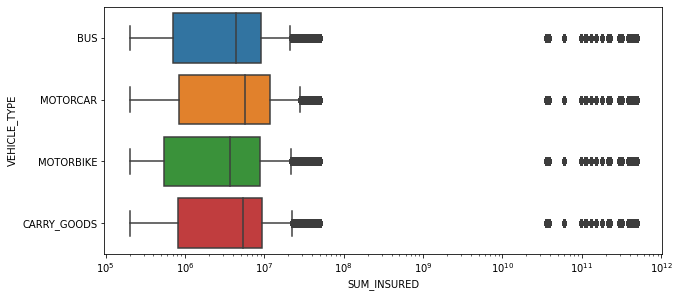

In [13]:
# Check Outlier in Sum Insured
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 1, 1)
sns.boxplot(x=datamart.SUM_INSURED,y = datamart.VEHICLE_TYPE)
ax.set_xscale('log')
plt.show()

In [14]:
# Remove Outlier in Sum Insured, replace it with max value

temp = datamart[['POLICY_IDENTIFIER','SUM_INSURED','VEHICLE_TYPE']]
result = []

def calculate_upper_wisker(data):
  Q1 = np.percentile(data, 25)
  Q3 = np.percentile(data, 75)
  Range = Q3 - Q1
  U = Q3 + 1.5 * Range
  return U 

for vehicle in temp.VEHICLE_TYPE.unique():
  data = temp[temp.VEHICLE_TYPE==vehicle]
  Upper = calculate_upper_wisker(data.SUM_INSURED)
  # data['OUTLIER_FLAG'] = np.where(data.SUM_INSURED > Upper,True,False)
  data['SUM_INSURED'] = np.where(data.SUM_INSURED > Upper,Upper,data.SUM_INSURED)

  result.append(data)

temp = pd.concat(result)

In [15]:
temp2 = datamart.copy()
temp2['SUM_INSURED'] = temp['SUM_INSURED']

In [16]:
datamart_clean = temp2.copy()

## Feature Engineering

In [17]:
datamart_clean.head().T

,0,1,2,3,4
POLICY_WRITTEN_BRANCH,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104
POLICY_IDENTIFIER,POLICY_2981310,POLICY_2746285,POLICY_2052928,POLICY_2507456,POLICY_2950161
PREVIOUS_INSURER_NAME,MAIN_INSURANCE,MAIN_INSURANCE,Others_ 23,MAIN_INSURANCE,MAIN_INSURANCE
POLICY_START_DATE,2014-05-05,2016-05-06,2013-01-22,2015-07-21,2016-01-06
POLICY_END_DATE,2015-05-04,2017-05-05,2014-01-21,2016-07-19,2017-01-04
CANCELLATION_DATE,2015-05-04,NaN,NaN,NaN,2017-01-02
SUM_INSURED,"7,800,000.00","27,880,000.00","380,000.00","4,940,000.00","4,480,000.00"
GWP,69911,51831,2654,24377,27824
COMPULSORY_DEDUCTABLE,2000,2000,1000,0,1000
PRODUCT,COMMERCIAL MOTOR MISCELLANEOUS VEHICLES,PRIVATE MOTOR 3 & 4 WHEELER,PRIVATE MOTOR 2 WHEELER,PRIVATE MOTOR 3 & 4 WHEELER,LONG TERM TWO WHEELER PACKAGE


In [18]:
temp = datamart_clean.copy()
temp['TARGET'] = np.where(temp.CLAIM_COUNT>=1,1,0)
temp['CUSTOMER_TYPE'] = np.where(temp.PREVIOUS_INSURER_NAME == 'MAIN_INSURANCE','EXISTING','NEW')
temp.POLICY_START_DATE = pd.to_datetime(temp.POLICY_START_DATE)
temp['PURCHASE_MONTH'] = pd.DatetimeIndex(temp.POLICY_START_DATE).month
temp['VEHICLE_AGE'] = pd.DatetimeIndex(temp.POLICY_START_DATE).year - temp.YEAR_OF_MANUFACTURE
temp['BUSINESS_TYPE'] = np.where(temp.PRODUCT.str.contains('COMMERCIAL'),'COMMERCIAL',np.where(temp.PRODUCT.str.contains('PRIVATE'),'PRIVATE','OTHER'))
temp.head().T

,0,1,2,3,4
POLICY_WRITTEN_BRANCH,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104
POLICY_IDENTIFIER,POLICY_2981310,POLICY_2746285,POLICY_2052928,POLICY_2507456,POLICY_2950161
PREVIOUS_INSURER_NAME,MAIN_INSURANCE,MAIN_INSURANCE,Others_ 23,MAIN_INSURANCE,MAIN_INSURANCE
POLICY_START_DATE,2014-05-05 00:00:00,2016-05-06 00:00:00,2013-01-22 00:00:00,2015-07-21 00:00:00,2016-01-06 00:00:00
POLICY_END_DATE,2015-05-04,2017-05-05,2014-01-21,2016-07-19,2017-01-04
CANCELLATION_DATE,2015-05-04,NaN,NaN,NaN,2017-01-02
SUM_INSURED,"7,800,000.00","27,880,000.00","380,000.00","4,940,000.00","4,480,000.00"
GWP,69911,51831,2654,24377,27824
COMPULSORY_DEDUCTABLE,2000,2000,1000,0,1000
PRODUCT,COMMERCIAL MOTOR MISCELLANEOUS VEHICLES,PRIVATE MOTOR 3 & 4 WHEELER,PRIVATE MOTOR 2 WHEELER,PRIVATE MOTOR 3 & 4 WHEELER,LONG TERM TWO WHEELER PACKAGE


In [19]:
# Extract previous policy information for each customer
temp2 = temp[temp.CANCELLATION_DATE.isna()][['CUSTOMER_IDENTIFIER','VEHICLE_IDENTIFIER','POLICY_START_DATE','POLICY_END_DATE','CLAIM_COUNT','CLAIM_AMOUNT']].sort_values(by = ['CUSTOMER_IDENTIFIER','POLICY_START_DATE'],ascending=True)
temp2.head()

,CUSTOMER_IDENTIFIER,VEHICLE_IDENTIFIER,POLICY_START_DATE,POLICY_END_DATE,CLAIM_COUNT,CLAIM_AMOUNT
3399624,CUSTOMER_1,VEHICLE_1057258,2016-10-30,2017-10-29,1.00,"20,318.00"
3289503,CUSTOMER_10,VEHICLE_946884,2012-10-13,2013-10-12,1.00,"4,708.00"
803573,CUSTOMER_100,VEHICLE_1394226,2015-10-09,2016-10-07,nan,nan
1328193,CUSTOMER_100,VEHICLE_1394226,2016-10-03,2017-10-02,nan,nan
3239141,CUSTOMER_1000,VEHICLE_1415386,2012-10-24,2013-10-23,nan,nan


In [20]:
pd.pivot_table(temp2,index='CUSTOMER_IDENTIFIER',aggfunc={'CLAIM_COUNT':'count'}).reset_index().sort_values(by='CLAIM_COUNT',ascending=False).head(10)

,CUSTOMER_IDENTIFIER,CLAIM_COUNT
486911,CUSTOMER_705545,6
600334,CUSTOMER_854462,6
491069,CUSTOMER_710951,6
529561,CUSTOMER_761721,5
635318,CUSTOMER_900359,5
180177,CUSTOMER_301925,5
224592,CUSTOMER_360409,5
674239,CUSTOMER_951568,5
387403,CUSTOMER_574679,5
423560,CUSTOMER_622148,5


In [21]:
# Example of repeat customer
temp2[temp2.CUSTOMER_IDENTIFIER == 'CUSTOMER_705545']

,CUSTOMER_IDENTIFIER,VEHICLE_IDENTIFIER,POLICY_START_DATE,POLICY_END_DATE,CLAIM_COUNT,CLAIM_AMOUNT
2380022,CUSTOMER_705545,VEHICLE_214261,2012-05-06,2013-05-05,1.00,"195,580.00"
1956261,CUSTOMER_705545,VEHICLE_214261,2012-10-28,2013-10-27,1.00,"3,538.00"
1994419,CUSTOMER_705545,VEHICLE_214261,2013-11-07,2014-11-06,2.00,"7,425.00"
1605120,CUSTOMER_705545,VEHICLE_214261,2014-08-15,2015-08-14,2.00,"35,063.00"
392531,CUSTOMER_705545,VEHICLE_214261,2017-07-17,2018-07-16,1.00,"27,704.00"
2561743,CUSTOMER_705545,VEHICLE_214261,2018-07-19,2019-07-18,1.00,"15,296.00"


In [22]:
# Feature Engineering on repeat customer
temp3 = temp2.copy()
temp3['PREVIOUS_START_DATE'] = pd.to_datetime(temp3.groupby(['CUSTOMER_IDENTIFIER','VEHICLE_IDENTIFIER'])['POLICY_START_DATE'].shift(1))
temp3['PREVIOUS_END_DATE'] = pd.to_datetime(temp3.groupby(['CUSTOMER_IDENTIFIER','VEHICLE_IDENTIFIER'])['POLICY_END_DATE'].shift(1))
temp3['PREVIOUS_CLAIM_COUNT'] = temp3.groupby(['CUSTOMER_IDENTIFIER','VEHICLE_IDENTIFIER'])['CLAIM_COUNT'].shift(1)
temp3['PREVIOUS_CLAIM_AMOUNT'] = temp3.groupby(['CUSTOMER_IDENTIFIER','VEHICLE_IDENTIFIER'])['CLAIM_AMOUNT'].shift(1)

In [23]:
temp3['SAME_VEHICLE_INSURED'] = np.where(temp3.PREVIOUS_START_DATE.isna(),False,True)
temp3['PREVIOUS_POLICIES_CLAIM'] = np.where(temp3.PREVIOUS_CLAIM_COUNT.isna(),False,True)
temp3['PERIOD_TO_NEXT_POLICIES'] = np.where(temp3.PREVIOUS_END_DATE.isna(),0,(temp3.POLICY_START_DATE - temp3.PREVIOUS_END_DATE))

In [24]:
temp4 = temp3[~temp3.PREVIOUS_START_DATE.isnull()]
temp4.drop(['PREVIOUS_START_DATE','PREVIOUS_END_DATE','CLAIM_AMOUNT','CLAIM_COUNT'],axis=1,inplace=True)

In [25]:
temp4.head()

,CUSTOMER_IDENTIFIER,VEHICLE_IDENTIFIER,POLICY_START_DATE,POLICY_END_DATE,PREVIOUS_CLAIM_COUNT,PREVIOUS_CLAIM_AMOUNT,SAME_VEHICLE_INSURED,PREVIOUS_POLICIES_CLAIM,PERIOD_TO_NEXT_POLICIES
1328193,CUSTOMER_100,VEHICLE_1394226,2016-10-03,2017-10-02,nan,nan,True,False,-4 days
962714,CUSTOMER_1000,VEHICLE_46254,2013-10-05,2014-10-04,nan,nan,True,False,-83 days
1410075,CUSTOMER_1000,VEHICLE_46254,2017-05-01,2018-04-30,nan,nan,True,False,940 days
2468556,CUSTOMER_1000000,VEHICLE_205603,2016-03-25,2017-03-24,nan,nan,True,False,267 days
2443541,CUSTOMER_1000003,VEHICLE_57310,2016-11-16,2017-11-15,1.00,"141,579.00",True,True,691 days


In [26]:
temp5 = pd.merge(temp,temp4,how='left',on = ['CUSTOMER_IDENTIFIER','VEHICLE_IDENTIFIER','POLICY_START_DATE','POLICY_END_DATE'])
temp5.head().T

,0,1,2,3,4
POLICY_WRITTEN_BRANCH,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104,BRANCH_104
POLICY_IDENTIFIER,POLICY_2981310,POLICY_2746285,POLICY_2052928,POLICY_2507456,POLICY_2950161
PREVIOUS_INSURER_NAME,MAIN_INSURANCE,MAIN_INSURANCE,Others_ 23,MAIN_INSURANCE,MAIN_INSURANCE
POLICY_START_DATE,2014-05-05 00:00:00,2016-05-06 00:00:00,2013-01-22 00:00:00,2015-07-21 00:00:00,2016-01-06 00:00:00
POLICY_END_DATE,2015-05-04,2017-05-05,2014-01-21,2016-07-19,2017-01-04
CANCELLATION_DATE,2015-05-04,NaN,NaN,NaN,2017-01-02
SUM_INSURED,"7,800,000.00","27,880,000.00","380,000.00","4,940,000.00","4,480,000.00"
GWP,69911,51831,2654,24377,27824
COMPULSORY_DEDUCTABLE,2000,2000,1000,0,1000
PRODUCT,COMMERCIAL MOTOR MISCELLANEOUS VEHICLES,PRIVATE MOTOR 3 & 4 WHEELER,PRIVATE MOTOR 2 WHEELER,PRIVATE MOTOR 3 & 4 WHEELER,LONG TERM TWO WHEELER PACKAGE


In [27]:
temp6 = temp5[temp5.CANCELLATION_DATE.isna()]

In [28]:
temp6['EXPERIENCE_CLAIM'] = np.where(temp6.PREVIOUS_POLICIES_CLAIM.isna(),'NEVER CLAIM','HAVE CLAIM')
temp6['EXPERIENCE_CLAIM_SEVERITY'] = np.where(temp6.PREVIOUS_CLAIM_AMOUNT.isna(),'NEVER CLAIM',
                                              np.where(temp6.PREVIOUS_CLAIM_AMOUNT<5000,'MINOR CLAIM',
                                                       np.where(temp6.PREVIOUS_CLAIM_AMOUNT<20000,'SMALL CLAIM',
                                                                np.where(temp6.PREVIOUS_CLAIM_AMOUNT<50000,'MEDIUM CLAIM','MAJOR CLAIM'
                                                                ))))
temp6['SAME_VEHICLE_INSURED'] = np.where(temp6.CUSTOMER_TYPE=='NEW','NEW CUSTOMER',
                                         np.where(temp6.SAME_VEHICLE_INSURED==True,'SAME VEHICLE','DIFFERENT VEHICLE'))

temp6['RENEWAL_PERIOD'] = np.where(temp6.PERIOD_TO_NEXT_POLICIES.isnull(),'NEW POLICY',
                                 np.where(temp6.PERIOD_TO_NEXT_POLICIES.dt.days<0,'BEFORE POLICY END',
                                          np.where(temp6.PERIOD_TO_NEXT_POLICIES.dt.days<30,'ONE MONTH BEFORE',
                                                   np.where(temp6.PERIOD_TO_NEXT_POLICIES.dt.days<180,'SIX MONTH BEFORE',
                                                            np.where(temp6.PERIOD_TO_NEXT_POLICIES.dt.days<360,'ONE YEAR BEFORE','MORE THAN ONE YEAR')))))

temp6['PREVIOUS_POLICIES_CLAIM'] = np.where(temp6.PREVIOUS_POLICIES_CLAIM.isna(),'NEW POLICY',
                                            np.where(temp6.PREVIOUS_POLICIES_CLAIM,'YES','NO'))

In [29]:
pd.pivot_table(temp6,index='PREVIOUS_POLICIES_CLAIM',aggfunc={'GWP':'count'})

,GWP
PREVIOUS_POLICIES_CLAIM,
NEW POLICY,1073956
NO,652900
YES,53516


In [30]:
temp6.drop(['PREVIOUS_INSURER_NAME','POLICY_START_DATE','POLICY_END_DATE','CANCELLATION_DATE',
            'PRODUCT','CLAIM_COUNT','CLAIM_AMOUNT','CUSTOMER_IDENTIFIER','VEHICLE_IDENTIFIER','PREVIOUS_CLAIM_COUNT','PREVIOUS_CLAIM_AMOUNT','PERIOD_TO_NEXT_POLICIES'],axis=1,inplace=True)
df_model = temp6.copy()

In [31]:
df_model.head()

,POLICY_WRITTEN_BRANCH,POLICY_IDENTIFIER,SUM_INSURED,GWP,COMPULSORY_DEDUCTABLE,PRODUCT_CODE,YEAR_OF_MANUFACTURE,MAKE_OF_VEHICLE,VEHICLE_TYPE,SEATING_CAPACITY,ENGINE_SIZE_CC,VEHICLE_GROSS_WEIGHT,GENDER,DRIVING_EXPERIENCE,TARGET,CUSTOMER_TYPE,PURCHASE_MONTH,VEHICLE_AGE,BUSINESS_TYPE,SAME_VEHICLE_INSURED,PREVIOUS_POLICIES_CLAIM,EXPERIENCE_CLAIM,EXPERIENCE_CLAIM_SEVERITY,RENEWAL_PERIOD
1,BRANCH_104,POLICY_2746285,"27,880,000.00",51831,2000,product_ 1,2007,Nissan,MOTORCAR,5,1300,64000,M,THREE_TO_FIVE_YEARS,1,EXISTING,5,9,PRIVATE,DIFFERENT VEHICLE,NEW POLICY,NEVER CLAIM,NEVER CLAIM,NEW POLICY
2,BRANCH_104,POLICY_2052928,"380,000.00",2654,1000,product_ 2,2011,ESCORT,MOTORBIKE,1,840,41000,M,THREE_TO_FIVE_YEARS,0,NEW,1,2,PRIVATE,NEW CUSTOMER,NEW POLICY,NEVER CLAIM,NEVER CLAIM,NEW POLICY
3,BRANCH_104,POLICY_2507456,"4,940,000.00",24377,0,product_ 1,2010,Aston Martin,MOTORCAR,3,1135,2800,F,ONE_TO_THREE_YEARS,0,EXISTING,7,5,PRIVATE,DIFFERENT VEHICLE,NEW POLICY,NEVER CLAIM,NEVER CLAIM,NEW POLICY
6,BRANCH_104,POLICY_2138054,"220,000.00",2175,1000,product_ 6,2004,JOHN DEERE,MOTORBIKE,2,580,2100,M,FIFTEEN_YEARS_AND_ABOVE,1,NEW,3,9,OTHER,NEW CUSTOMER,NEW POLICY,NEVER CLAIM,NEVER CLAIM,NEW POLICY
7,BRANCH_104,POLICY_2731716,"19,350,000.00",53009,1000,product_ 6,2000,DAEWOO MOTORS,MOTORBIKE,2,980,880,M,THREE_TO_FIVE_YEARS,0,EXISTING,5,16,OTHER,SAME VEHICLE,NO,HAVE CLAIM,NEVER CLAIM,BEFORE POLICY END


## Encode Categorical Variable

In [32]:
df_model.dtypes

POLICY_WRITTEN_BRANCH         object
POLICY_IDENTIFIER             object
SUM_INSURED                  float64
GWP                            int64
COMPULSORY_DEDUCTABLE          int64
PRODUCT_CODE                  object
YEAR_OF_MANUFACTURE            int64
MAKE_OF_VEHICLE               object
VEHICLE_TYPE                  object
SEATING_CAPACITY               int64
ENGINE_SIZE_CC                 int64
VEHICLE_GROSS_WEIGHT           int64
GENDER                        object
DRIVING_EXPERIENCE            object
TARGET                         int64
CUSTOMER_TYPE                 object
PURCHASE_MONTH                 int64
VEHICLE_AGE                    int64
BUSINESS_TYPE                 object
SAME_VEHICLE_INSURED          object
PREVIOUS_POLICIES_CLAIM       object
EXPERIENCE_CLAIM              object
EXPERIENCE_CLAIM_SEVERITY     object
RENEWAL_PERIOD                object
dtype: object

In [33]:
df_numerical = df_model.select_dtypes(exclude='object')
df_categorical = df_model.select_dtypes(include='object')
df_numerical.drop('TARGET',axis=1,inplace=True)
target = df_model.TARGET
id = df_model.POLICY_IDENTIFIER

In [34]:
df_categorical.describe()

,POLICY_WRITTEN_BRANCH,POLICY_IDENTIFIER,PRODUCT_CODE,MAKE_OF_VEHICLE,VEHICLE_TYPE,GENDER,DRIVING_EXPERIENCE,CUSTOMER_TYPE,BUSINESS_TYPE,SAME_VEHICLE_INSURED,PREVIOUS_POLICIES_CLAIM,EXPERIENCE_CLAIM,EXPERIENCE_CLAIM_SEVERITY,RENEWAL_PERIOD
count,1780372,1780372,1780372,1780372,1780372,1780372,1780372,1780372,1780372,1780372,1780372,1780372,1780372,1780372
unique,123,1780000,7,46,4,2,6,2,3,3,3,2,5,6
top,BRANCH_34,POLICY_2590233,product_ 1,YAMAHA,MOTORCAR,M,THREE_TO_FIVE_YEARS,EXISTING,PRIVATE,NEW CUSTOMER,NEW POLICY,NEVER CLAIM,NEVER CLAIM,NEW POLICY
freq,72805,2,593684,54714,742107,1426339,1317606,977355,799947,803017,1073956,1073956,1726856,1073956


Encode variable split into 2,
1. One Hot Encode
2. Target Encode
3. Binary Encode 

In [35]:
# Encode category
onehot_encode = ['VEHICLE_TYPE','GENDER','CUSTOMER_TYPE','BUSINESS_TYPE','SAME_VEHICLE_INSURED','PREVIOUS_POLICIES_CLAIM','EXPERIENCE_CLAIM']
target_encode = ['POLICY_WRITTEN_BRANCH','MAKE_OF_VEHICLE']
binary_encode = ['PRODUCT_CODE','DRIVING_EXPERIENCE','EXPERIENCE_CLAIM_SEVERITY','RENEWAL_PERIOD']

temp_onehot = df_categorical[onehot_encode]
temp_target = df_categorical[target_encode]
temp_binary = df_categorical[binary_encode]

In [36]:
# One hot encode
temp_onehot2 = pd.get_dummies(temp_onehot,drop_first=True)
temp_onehot2.head()

,VEHICLE_TYPE_CARRY_GOODS,VEHICLE_TYPE_MOTORBIKE,VEHICLE_TYPE_MOTORCAR,GENDER_M,CUSTOMER_TYPE_NEW,BUSINESS_TYPE_OTHER,BUSINESS_TYPE_PRIVATE,SAME_VEHICLE_INSURED_NEW CUSTOMER,SAME_VEHICLE_INSURED_SAME VEHICLE,PREVIOUS_POLICIES_CLAIM_NO,PREVIOUS_POLICIES_CLAIM_YES,EXPERIENCE_CLAIM_NEVER CLAIM
1,0,0,1,1,0,0,1,0,0,0,0,1
2,0,1,0,1,1,0,1,1,0,0,0,1
3,0,0,1,0,0,0,1,0,0,0,0,1
6,0,1,0,1,1,1,0,1,0,0,0,1
7,0,1,0,1,0,1,0,0,1,1,0,0


In [37]:
# target encode

temp_target1 = pd.pivot_table(datamart,index='POLICY_WRITTEN_BRANCH',aggfunc={'GWP':'sum','SUM_INSURED':'count','CLAIM_AMOUNT':'sum','CLAIM_COUNT':'sum'}).reset_index()
temp_target1['LOSS_RATIO_BRANCH'] = temp_target1['CLAIM_AMOUNT']/temp_target1['GWP']
temp_target1['INCIDENT_RATE_BRANCH'] = temp_target1['CLAIM_COUNT']/temp_target1['SUM_INSURED']
temp_target_branch = temp_target1[['POLICY_WRITTEN_BRANCH','LOSS_RATIO_BRANCH','INCIDENT_RATE_BRANCH']]

temp_target1 = pd.pivot_table(datamart,index='MAKE_OF_VEHICLE',aggfunc={'GWP':'sum','SUM_INSURED':'count','CLAIM_AMOUNT':'sum','CLAIM_COUNT':'sum'}).reset_index()
temp_target1['LOSS_RATIO_VEHICLE'] = temp_target1['CLAIM_AMOUNT']/temp_target1['GWP']
temp_target1['INCIDENT_RATE_VEHICLE'] = temp_target1['CLAIM_COUNT']/temp_target1['SUM_INSURED']
temp_target_vehicle = temp_target1[['MAKE_OF_VEHICLE','LOSS_RATIO_VEHICLE','INCIDENT_RATE_VEHICLE']]


In [38]:
temp_target1 = pd.merge(df_categorical[['MAKE_OF_VEHICLE','POLICY_WRITTEN_BRANCH']],temp_target_branch,how='left',on='POLICY_WRITTEN_BRANCH')
temp_target2 = pd.merge(temp_target1,temp_target_vehicle,how='left',on='MAKE_OF_VEHICLE')

In [39]:
# binary encode

encoder= ce.BinaryEncoder(cols=binary_encode,return_df=True)
temp_binary2=encoder.fit_transform(temp_binary) 

In [40]:
temp1 = pd.concat([target,id,df_numerical,temp_onehot2,temp_binary2,df_categorical[['MAKE_OF_VEHICLE','POLICY_WRITTEN_BRANCH']]],axis=1)
temp2 = pd.merge(temp1,temp_target_branch,how='left',on='POLICY_WRITTEN_BRANCH')
temp3 = pd.merge(temp2,temp_target_vehicle,how='left',on='MAKE_OF_VEHICLE')
temp3.drop(['POLICY_WRITTEN_BRANCH','MAKE_OF_VEHICLE'],axis=1,inplace=True)
df_encode = temp3.copy()

## Train Test Split

In [41]:
del datamart_clean, df_model, df_numerical, df_categorical, target, df_customer, df_historical_claims, df_open_claims, df_policies_new, df_vehicle_new

In [42]:
X = df_encode.iloc[:,1:].values 
y = df_encode.iloc[:,0].values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.5)
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test,train_size=0.5)

In [44]:
X_train_id = X_train[:,0]
X_test_id = X_test[:,0]
X_val_id = X_val[:,0]

X_train = X_train[:,1:]
X_test = X_test[:,1:]
X_val = X_val[:,1:]

## Model Training

In [45]:
# Random Forest
model_rf = RandomForestClassifier(n_estimators=5)
model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [46]:
# Xgboost
model_xgb = xgboost.XGBClassifier(objective='binary:logistic'
                            ,learning_rate= 0.1
                            ,max_depth= 4
                            ,min_child_weight= 6
                            ,reg_alpha= 0.05)
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=6, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

## Model Evaluation

In [47]:
def model_evaluation(classfier,X,y):
    y_proba = classfier.predict_proba(X)
    y_pred = classfier.predict(X)
    
    cm = confusion_matrix(y,y_pred)
    print('Confussin Matrix :')
    print(cm)
    print('\nModel Metrics')
    print('Accuracy   :{}'.format(accuracy_score(y,y_pred)))
    print('Precision  :{}'.format(precision_score(y,y_pred)))
    print('Recall     :{}'.format(recall_score(y,y_pred)))
    print('F1         :{}'.format(f1_score(y,y_pred)))
    print('ROC AUC    :{}'.format(roc_auc_score(y,y_pred))) 

In [48]:
print('Train')
model_evaluation(model_rf,X_train,y_train)
print('Test')
model_evaluation(model_rf,X_test,y_test)
print('Val')
model_evaluation(model_rf,X_val,y_val)

Train
Confussin Matrix :
[[732747   3651]
 [ 11239 142549]]

Model Metrics
Accuracy   :0.9832731586432498
Precision  :0.9750273597811218
Recall     :0.9269188753348766
F1         :0.9503646812539168
ROC AUC    :0.960980479278089
Test
Confussin Matrix :
[[344423  23675]
 [ 43471  33524]]

Model Metrics
Accuracy   :0.8491416400617399
Precision  :0.5860941624853582
Recall     :0.4354048964218456
F1         :0.4996348569980774
ROC AUC    :0.6855438926088819
Val
Confussin Matrix :
[[344606  23937]
 [ 43084  33466]]

Model Metrics
Accuracy   :0.8494224802457014
Precision  :0.5830008884553072
Recall     :0.4371783148269105
F1         :0.49966779392772087
ROC AUC    :0.6861139781263708


In [49]:
print('Train')
model_evaluation(model_xgb,X_train,y_train)
print('Test')
model_evaluation(model_xgb,X_test,y_test)
print('Val')
model_evaluation(model_xgb,X_val,y_val)

Train
Confussin Matrix :
[[736153    245]
 [120872  32916]]

Model Metrics
Accuracy   :0.8639419177565139
Precision  :0.9926118030216218
Recall     :0.2140349051941634
F1         :0.3521388186082835
ROC AUC    :0.6068511023354026
Test
Confussin Matrix :
[[367980    118]
 [ 60602  16393]]

Model Metrics
Accuracy   :0.8635790722388355
Precision  :0.9928532493489189
Recall     :0.21290992921618287
F1         :0.35062990610228223
ROC AUC    :0.6062946812053019
Val
Confussin Matrix :
[[368429    114]
 [ 60166  16384]]

Model Metrics
Accuracy   :0.8645676296863801
Precision  :0.9930900715238211
Recall     :0.2140300457217505
F1         :0.3521623248215975
ROC AUC    :0.6068603597686445


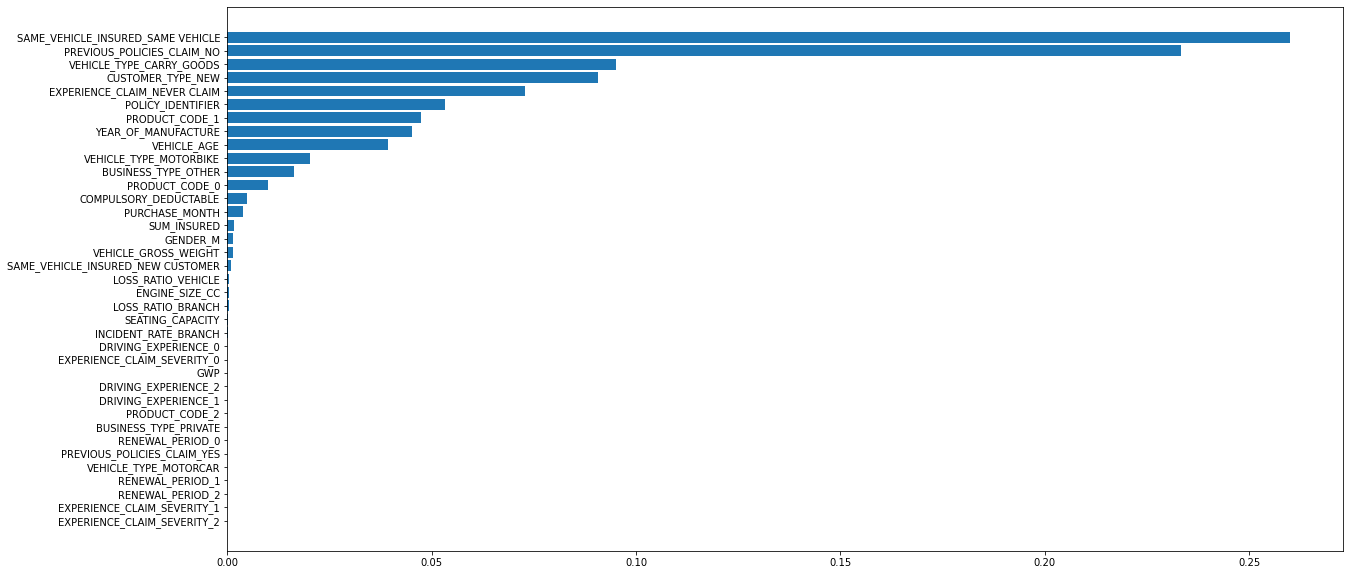

In [50]:
sorted_idx = model_xgb.feature_importances_.argsort()
plt.figure(figsize=(20,10))
plt.barh(df_encode.iloc[:,1:].columns[sorted_idx], model_xgb.feature_importances_[sorted_idx])
plt.show()

 99%|===================| 49717/50000 [01:28<00:00]       

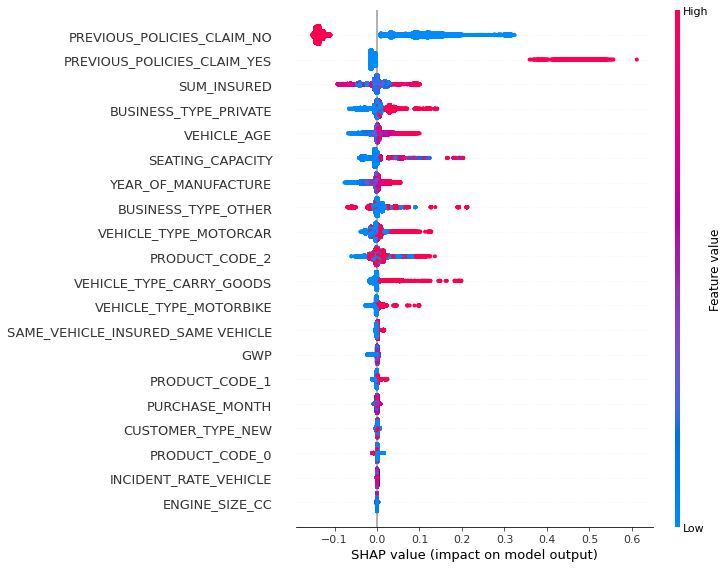

In [52]:
shap_values = shap.TreeExplainer(model_xgb,data = df_encode.iloc[:50000,2:],model_output='probability').shap_values(df_encode.iloc[:50000,2:])
f = plt.figure()
shap.summary_plot(shap_values, df_encode.iloc[:50000,2:])

## Model Inference

In [61]:
# Predict Output
y_pred_proba_train = model_xgb.predict_proba(X_train)[:,1]
y_pred_train = model_xgb.predict(X_train)

y_pred_proba_test = model_xgb.predict_proba(X_test)[:,1]
y_pred_test = model_xgb.predict(X_test)

y_pred_proba_val = model_xgb.predict_proba(X_val)[:,1]
y_pred_val = model_xgb.predict(X_val)

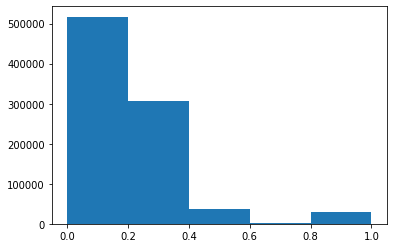

In [57]:
plt.hist(y_pred_proba_train,bins=5)
plt.show()

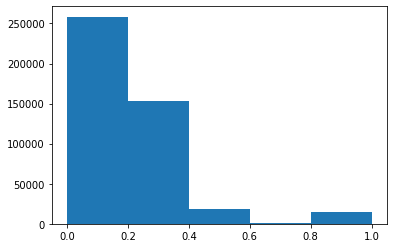

In [58]:
plt.hist(y_pred_proba_test,bins=5)
plt.show()

In [86]:
# Inferencing Result
df_result_train = pd.DataFrame(X_train_id)
df_result_train['pred'] = y_pred_train
df_result_train['proba'] = y_pred_proba_train
df_result_train['actual'] = y_train

df_result_test = pd.DataFrame(X_test_id)
df_result_test['pred'] = y_pred_test
df_result_test['proba'] = y_pred_proba_test
df_result_test['actual'] = y_test

df_result_val = pd.DataFrame(X_val_id)
df_result_val['pred'] = y_pred_val
df_result_val['proba'] = y_pred_proba_val
df_result_val['actual'] = y_val

In [88]:
temp = df_result_train.append(df_result_test)
df_result = temp.append(df_result_val)
df_result.columns = ['POLICY_IDENTIFIER','PRED','PROBA','ACTUAL']

In [89]:
df_result.head()

,POLICY_IDENTIFIER,PRED,PROBA,ACTUAL
0,POLICY_2179960,0,0.00,0
1,POLICY_2398834,0,0.21,0
2,POLICY_2716477,0,0.29,0
3,POLICY_2388058,0,0.00,0
4,POLICY_1486915,0,0.28,0


In [104]:
datamart_pred = pd.merge(datamart,df_result,how='inner',on='POLICY_IDENTIFIER')

def premium_loading(prob):
  if prob < 0.5:
    return 0
  elif prob < 0.75:
    return 25
  elif prob <= 1:
    return 50

datamart_pred['GWP_ADJUSTED'] = datamart_pred['GWP']/(1 - datamart_pred['PROBA'].apply(premium_loading)/100 )

In [91]:
bucket = client.get_bucket('munich_re_dev')
bucket.blob('data/datamart_pred.csv').upload_from_string(datamart_pred.to_csv(), 'text/csv')

# Summary

The model return a good performance, with precision 99%. it means, from all the policy submission, all the customer with high probability of claim, will claim. The model is evaluated by using precison because, we want to avoid giving a high premium rates to wrong customer.

Model is check using 3 set of the data (Train, Test, Val) all return similar performance, hence we can conclude that the model is fit.

In [93]:
print('Train')
model_evaluation(model_xgb,X_train,y_train)
print('Test')
model_evaluation(model_xgb,X_test,y_test)
print('Val')
model_evaluation(model_xgb,X_val,y_val)

Train
Confussin Matrix :
[[736153    245]
 [120872  32916]]

Model Metrics
Accuracy   :0.8639419177565139
Precision  :0.9926118030216218
Recall     :0.2140349051941634
F1         :0.3521388186082835
ROC AUC    :0.6068511023354026
Test
Confussin Matrix :
[[367980    118]
 [ 60602  16393]]

Model Metrics
Accuracy   :0.8635790722388355
Precision  :0.9928532493489189
Recall     :0.21290992921618287
F1         :0.35062990610228223
ROC AUC    :0.6062946812053019
Val
Confussin Matrix :
[[368429    114]
 [ 60166  16384]]

Model Metrics
Accuracy   :0.8645676296863801
Precision  :0.9930900715238211
Recall     :0.2140300457217505
F1         :0.3521623248215975
ROC AUC    :0.6068603597686445


Using predicted probability of policy submission, customer will get a premium loading if the probability of claim is meet a threshold.

Here is the thershold 
1. No Loading for probability of claim < 50%
2. Loading 25% if probability of claim 50% < x < 75%
3. Loading 50% if probability of claim 75% < x < 100%

It means only customer with high probability of claim, will get a loading and rest of the customer with low probability of claim will pay the same amount.

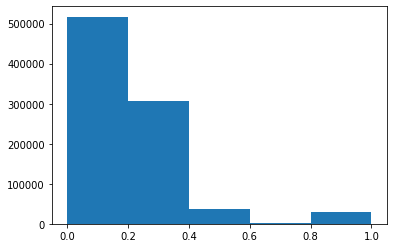

In [94]:
plt.hist(y_pred_proba_train,bins=5)
plt.show()

Using this approach, we are manage to lower down the claim ratio by 3%. Loss ratio will decreased by 18%, if the customer decide to withdraw the policy application after getting adjusted GWP

In [109]:
claim_ratio = datamart_pred.CLAIM_AMOUNT.sum()/datamart_pred.GWP.sum()
claim_ratio_adjusted = datamart_pred.CLAIM_AMOUNT.sum()/datamart_pred.GWP_ADJUSTED.sum()

print('Customer Apply')
print('GWP Original Loss Ratio : {}%'.format(claim_ratio * 100))
print('GWP Adjusted Loss Ratio : {}%'.format(claim_ratio_adjusted * 100))

claim_ratio = datamart_pred.CLAIM_AMOUNT.sum()/datamart_pred.GWP.sum()
claim_ratio_adjusted = datamart_pred[datamart_pred['PRED']==0].CLAIM_AMOUNT.sum()/datamart_pred[datamart_pred['PRED']==0].GWP_ADJUSTED.sum()

print('Customer Withdraw')
print('GWP Original Loss Ratio : {}%'.format(claim_ratio * 100))
print('GWP Adjusted Loss Ratio : {}%'.format(claim_ratio_adjusted * 100))

Customer Apply
GWP Original Loss Ratio : 17.114309184331546%
GWP Adjusted Loss Ratio : 16.54664451625409%
Customer Withdraw
GWP Original Loss Ratio : 17.114309184331546%
GWP Adjusted Loss Ratio : 14.043189852358479%
